In [ ]:
import os
from glob import glob

base_path = "/content/drive/MyDrive/processed_faces_final/"

real_dirs = [os.path.join(base_path, "Celeb-real"),
             os.path.join(base_path, "original")]

fake_dirs = [os.path.join(base_path, "Celeb-synthesis"),
             os.path.join(base_path, "DeepFakeDetection")]


In [ ]:
def get_all_frames(folders):
    frame_paths = []
    for folder in folders:
        # Collect all jpg frames recursively
        frame_paths.extend(glob(os.path.join(folder, "**", "*.jpg"), recursive=True))
    return frame_paths

real_frames = get_all_frames(real_dirs)
fake_frames = get_all_frames(fake_dirs)

print(f"Total Real Frames: {len(real_frames)}")
print(f"Total Fake Frames: {len(fake_frames)}")


Total Real Frames: 40689
Total Fake Frames: 43206


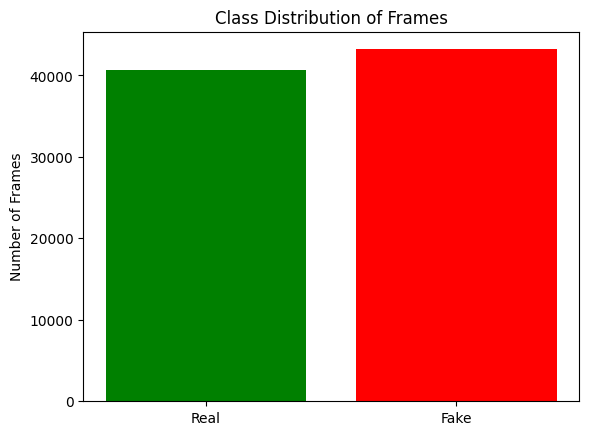

In [ ]:
import matplotlib.pyplot as plt

labels = ['Real', 'Fake']
counts = [len(real_frames), len(fake_frames)]

plt.bar(labels, counts, color=['green', 'red'])
plt.title("Class Distribution of Frames")
plt.ylabel("Number of Frames")
plt.show()


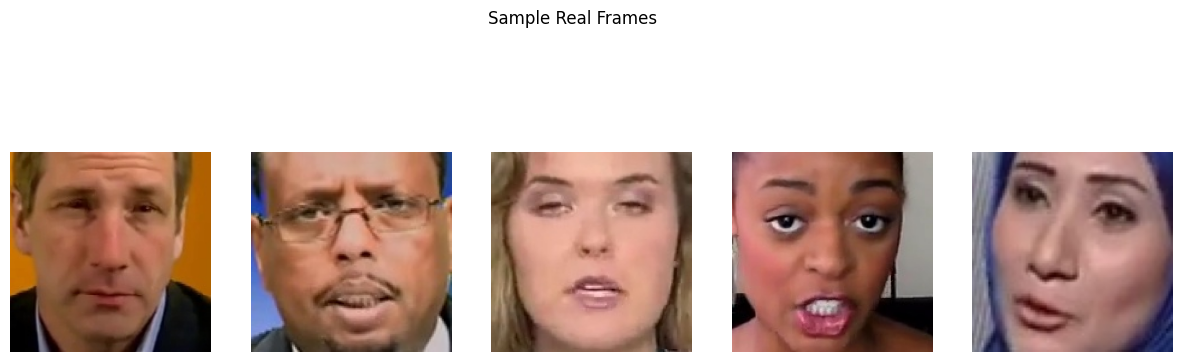

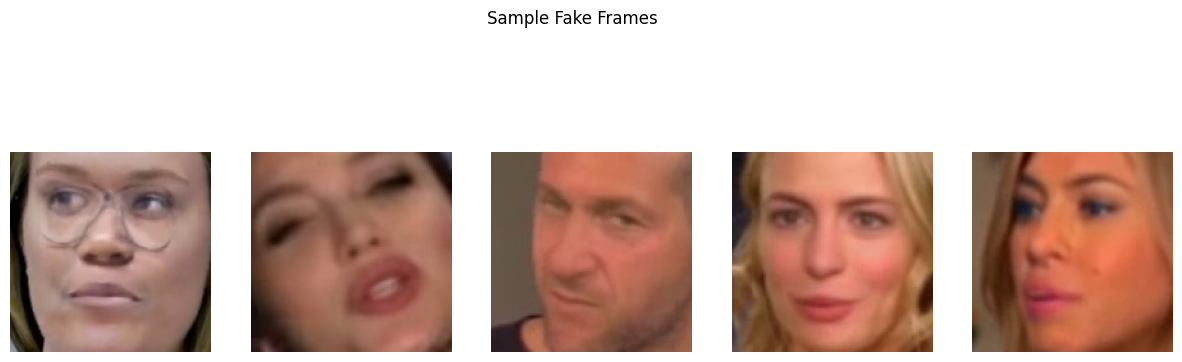

In [ ]:
import cv2
import random

def show_random_frames(frame_list, title, n=5):
    random_frames = random.sample(frame_list, n)
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random_frames):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_random_frames(real_frames, "Sample Real Frames")
show_random_frames(fake_frames, "Sample Fake Frames")


In [ ]:
dataset = {
    "real": real_frames,
    "fake": fake_frames
}

print(f"Sample real frame path: {dataset['real'][0]}")
print(f"Sample fake frame path: {dataset['fake'][0]}")


Sample real frame path: /content/drive/MyDrive/processed_faces_final/Celeb-real/id16_0001/id16_0001_f0_d0.jpg
Sample fake frame path: /content/drive/MyDrive/processed_faces_final/Celeb-synthesis/id20_id19_0009/id20_id19_0009_f0_d0.jpg


In [ ]:
import cv2
import os
from glob import glob
import numpy as np

def variance_of_laplacian(image_path):
    """Calculate sharpness score using Variance of Laplacian."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0
    return cv2.Laplacian(img, cv2.CV_64F).var()

def sample_best_frames(video_folder, frames_per_video=50, temp_factor=2):
    """
    Select high-quality and diverse frames from a single video folder.

    Steps:
    1. Evenly sample 2× the target frames across the timeline.
    2. From those, pick top 'frames_per_video' based on sharpness.

    Args:
        video_folder (str): Path to a folder containing frames of one video.
        frames_per_video (int): Final number of frames to keep.
        temp_factor (int): Factor for initial over-sampling (default=2).

    Returns:
        List[str]: Final list of selected frame paths.
    """
    frames = sorted(glob(os.path.join(video_folder, "*.jpg")))
    if len(frames) == 0:
        return []

    # --- Step 1: Even temporal sampling ---
    step = max(1, len(frames) // (frames_per_video * temp_factor))
    temporally_sampled = frames[::step][:frames_per_video * temp_factor]

    # --- Step 2: Sharpness-based filtering ---
    sharpness_scores = [(f, variance_of_laplacian(f)) for f in temporally_sampled]
    sharpness_scores.sort(key=lambda x: x[1], reverse=True)

    # Final selection
    final_frames = [x[0] for x in sharpness_scores[:frames_per_video]]
    return final_frames

def process_dataset(parent_folders, frames_per_video=50):
    """
    Apply the combined sampling to an entire dataset with multiple videos.

    Args:
        parent_folders (list): List of parent folder paths containing videos.
        frames_per_video (int): Final number of frames per video.

    Returns:
        List[str]: List of selected frame paths for the entire dataset.
    """
    all_selected_frames = []
    for folder in parent_folders:
        video_folders = [os.path.join(folder, vid) for vid in os.listdir(folder) if os.path.isdir(os.path.join(folder, vid))]
        for video_folder in video_folders:
            selected = sample_best_frames(video_folder, frames_per_video=frames_per_video)
            all_selected_frames.extend(selected)
    return all_selected_frames


In [ ]:
real_sampled = process_dataset(real_dirs, frames_per_video=50)
fake_sampled = process_dataset(fake_dirs, frames_per_video=50)

print(f"Final Real Frames: {len(real_sampled)}")
print(f"Final Fake Frames: {len(fake_sampled)}")



Final Real Frames: 10000
Final Fake Frames: 9988
Sampled frame paths saved to sampled_frames.pkl


In [ ]:
import pickle
import os

# Create a folder in Drive for your project
save_dir = "/content/drive/MyDrive/processed_faces_final"
os.makedirs(save_dir, exist_ok=True)

# Save file
save_path = os.path.join(save_dir, "sampled_frames.pkl")

with open(save_path, "wb") as f:
    pickle.dump({
        "real": real_sampled,
        "fake": fake_sampled
    }, f)

print(f"Sampled frame paths saved to: {save_path}")

Sampled frame paths saved to: /content/drive/MyDrive/processed_faces_final/sampled_frames.pkl
